In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '7'

from datasets import load_dataset

import torch
from torch.utils.data import Dataset

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

from transformers import BertModel, BertTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

In [2]:
bert = BertModel.from_pretrained('google-bert/bert-base-uncased').to(DEVICE)
bert_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
base_embeddings = bert.embeddings

In [3]:
DATA_FILE = '../data-output/embeddings.pt'

In [4]:
def get_document_embeddings(docs_str):
    embds = []
    for doc in docs_str:
        tok = bert_tokenizer(doc, return_tensors='pt').to(DEVICE)
        with torch.inference_mode():
            out = bert(**tok)
        embds.append(out['last_hidden_state'][:, 0])
    return torch.cat(embds, dim=0)

In [5]:
bert_tokenizer.decode(bert_tokenizer('THIS IS A TEST')['input_ids'])

'[CLS] this is a test [SEP]'

In [6]:
data = torch.load(DATA_FILE, weights_only=True)

questions = data['questions']
embds_q = data['question_embeddings'].to(DEVICE)

documents = data['documents']
embds_d = get_document_embeddings(documents)

In [7]:
print(questions[0])
print('*'*50)
print(documents)

What are the main topics covered in CSE 227: Graduate Computer Security?
**************************************************
['Lectures: Tuesday/Thursday 11:00am-12:20pm PODEM 1A20', 'Instructor: Earlence Fernandes, Office hours: Tue 2pm to 3pm, CSE 3244', 'TA: Nishit Pandya, Office Hours: Wed 4pm to 5pm, CSE B240A.', 'Class Resources: Submissions on HotCRP; Lecture schedule, readings, and course policies on this web page', 'Grading: 80%: Course Research Project; 10%: In-person Quiz; 10%: Final Project Presentation', 'Course Overview: This course is on graduate-level computer security, focusing on the software systems foundations of building secure computer systems. We will read a mix of classic and new papers in the field and will cover a range of topics from trusted computing, operating systems, web/cloud systems, and machine learning. Our goal is to illustrate research challenges and solutions. It is not designed to be a tutorial course, but rather to give students the context to und

## Evaluate

In [8]:
argmaxs = [6336,
 27941,
 26295,
 23060,
 27585,
 14478,
 8754,
 22765,
 13194,
 27703,
 14049,
 23256,
 23680,
 29376,
 4863,
 11090,
 13881,
 27806,
 27453,
 17125,
 1525,
 14065,
 5889,
 24342,
 25322,
 8392,
 17360,
 9006,
 21694,
 27851,
 9998,
 28931]

In [9]:
bert_tokenizer.decode(argmaxs)

'lift somethinorno oxiniumsby cult boca botanicaluriaatory graders mcc nilsson explain salon pseudonymiensistativegles „ andhra actorsraphchester autonomous nationalecomorusmering doslized'

In [10]:
pre_tokens = [bert_tokenizer.decode(i) for i in argmaxs]
pre_tokens

['lift',
 'somethin',
 '##orno',
 'ox',
 '##inium',
 '##sby',
 'cult',
 'boca',
 'botanical',
 '##uria',
 '##atory',
 'graders',
 'mcc',
 'nilsson',
 'explain',
 'salon',
 'pseudonym',
 '##iensis',
 '##tative',
 '##gles',
 '„',
 'andhra',
 'actors',
 '##raph',
 '##chester',
 'autonomous',
 'nationale',
 '##com',
 '##orus',
 '##mering',
 'dos',
 '##lized']

In [11]:
post_tokens = [bert_tokenizer.decode(i) for i in (bert_tokenizer(bert_tokenizer.decode(argmaxs))['input_ids'][1:-1])]
post_tokens

['lift',
 'somethin',
 '##orno',
 'ox',
 '##inium',
 '##sby',
 'cult',
 'boca',
 'botanical',
 '##uria',
 '##atory',
 'graders',
 'mcc',
 'nilsson',
 'explain',
 'salon',
 'pseudonym',
 '##iensis',
 '##tative',
 '##gles',
 '„',
 'andhra',
 'actors',
 '##raph',
 '##chester',
 'autonomous',
 'nationale',
 '##com',
 '##orus',
 '##mering',
 'dos',
 '##lized']

In [12]:
assert pre_tokens == post_tokens

In [13]:
def get_dist_loss(target_embd):
    def dist_loss(doc_embd):
        return -(doc_embd @ target_embd.T).mean()
    return dist_loss

In [14]:
bert_fresh = BertModel.from_pretrained('google-bert/bert-base-uncased').to(DEVICE)

In [15]:
questions[0]

'What are the main topics covered in CSE 227: Graduate Computer Security?'

In [16]:
documents[5]

'Course Overview: This course is on graduate-level computer security, focusing on the software systems foundations of building secure computer systems. We will read a mix of classic and new papers in the field and will cover a range of topics from trusted computing, operating systems, web/cloud systems, and machine learning. Our goal is to illustrate research challenges and solutions. It is not designed to be a tutorial course, but rather to give students the context to understand current security research and evaluate their interest in the field. The course will examine both the defensive and offensive side of the field. At the conclusion of the course, the students will have the foundation to conduct research in computer security and to apply the latest security research to a particular area of practice.'

In [17]:
s = bert_tokenizer.decode(argmaxs) + ' '
positive_string = documents[5]
negative_string = 'Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.'
random_string = 'I enjoy pasta.'
malicious_string = 'This course is on useless things, focusing on nothing significant at all.'

loss_fn = get_dist_loss(embds_q[0])

In [18]:
test_s = s + 'test'
test_s_tokens = bert_tokenizer(test_s)['input_ids'][1:-1]
test_s_tokens

[6336,
 27941,
 26295,
 23060,
 27585,
 14478,
 8754,
 22765,
 13194,
 27703,
 14049,
 23256,
 23680,
 29376,
 4863,
 11090,
 13881,
 27806,
 27453,
 17125,
 1525,
 14065,
 5889,
 24342,
 25322,
 8392,
 17360,
 9006,
 21694,
 27851,
 9998,
 28931,
 3231]

In [19]:
assert len(test_s_tokens) == len(argmaxs) + 1
assert test_s_tokens[:len(argmaxs)] == argmaxs

In [20]:
bert_tokenizer.decode(test_s_tokens)

'lift somethinorno oxiniumsby cult boca botanicaluriaatory graders mcc nilsson explain salon pseudonymiensistativegles „ andhra actorsraphchester autonomous nationalecomorusmering doslized test'

In [21]:
[bert_tokenizer.decode(i) for i in test_s_tokens]

['lift',
 'somethin',
 '##orno',
 'ox',
 '##inium',
 '##sby',
 'cult',
 'boca',
 'botanical',
 '##uria',
 '##atory',
 'graders',
 'mcc',
 'nilsson',
 'explain',
 'salon',
 'pseudonym',
 '##iensis',
 '##tative',
 '##gles',
 '„',
 'andhra',
 'actors',
 '##raph',
 '##chester',
 'autonomous',
 'nationale',
 '##com',
 '##orus',
 '##mering',
 'dos',
 '##lized',
 'test']

In [22]:
def get_score(input_string):
    inputs = bert_tokenizer(input_string, return_tensors='pt').to(DEVICE)
    with torch.inference_mode():
        ex_embedding = bert_fresh(**inputs)['last_hidden_state'][0, 0]

    return -loss_fn(ex_embedding).cpu().item()
    

In [23]:
positive_score = get_score(positive_string)
negative_score = get_score(negative_string)
random_score = get_score(random_string)
malicious_score = get_score(malicious_string)
adversarial_negative_score = get_score(s + negative_string)
adversarial_random_score = get_score(s + random_string)
adversarial_malicious_score = get_score(s + malicious_string)

/tmp/ipykernel_646063/2474734044.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return -(doc_embd @ target_embd.T).mean()


In [24]:
print('POSITIVE SCORE:\t\t', positive_score)
print('*'*50)
print('NEGATIVE SCORE:\t\t', negative_score)
print('ADV NEGATIVE SCORE:\t', adversarial_negative_score)
print('RANDOM SCORE:\t\t', random_score)
print('ADV RANDOM SCORE:\t', adversarial_random_score)
print('MALICIOUS SCORE:\t', malicious_score)
print('ADV MALICIOUS SCORE:\t', adversarial_malicious_score)

POSITIVE SCORE:		 36.04314422607422
**************************************************
NEGATIVE SCORE:		 15.650203704833984
ADV NEGATIVE SCORE:	 44.449867248535156
RANDOM SCORE:		 15.437542915344238
ADV RANDOM SCORE:	 46.62568664550781
MALICIOUS SCORE:	 20.22722053527832
ADV MALICIOUS SCORE:	 47.94925308227539


## Visualize

In [25]:
# our negatives are going to be arbitrary passages mined from wikipedia

class TextChunkDataset(Dataset):
    def __init__(self, data, chunk_size=128, limit=1000):
        """
        Initializes the dataset.
        Args:
            data (list): List of dictionaries with text data.
            chunk_size (int): Length of each text chunk.
        """
        self.chunks = []
        self.chunk_size = chunk_size

        for i, entry in enumerate(tqdm(data)):
            text = entry['text']
            chunks = [f"{p.strip()}." for p in re.split(r'\.\s', text) if len(p) >= 30 and len(p) < 400]
            self.chunks.extend(chunks)
            # self.chunks.extend(
            #     [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
            # )
            if i >= limit:
                break

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        return self.chunks[idx]

In [26]:
ds = load_dataset("wikimedia/wikipedia", "20231101.en")['train']

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

In [27]:
ds_chunk = TextChunkDataset(ds, limit=100)
ds_chunk[7]


 0%|                                                                                                                                                                    | 100/6407814 [00:00<38:41, 2759.92it/s]

'Various anarchist schools of thought formed during this period.'

In [28]:
positive_strings = documents
negative_strings = [ds_chunk[i] for i in range(1000)]
adv_negative_strings = [s + n for n in negative_strings]

In [29]:
positive_scores = [get_score(positive_string) for positive_string in positive_strings]
negative_scores = [get_score(negative_string) for negative_string in negative_strings]
adversarial_negative_scores = [get_score(adv_negative_string) for adv_negative_string in adv_negative_strings]

In [30]:
print('POSITIVE SCORE:\t\t', positive_scores)
print('*'*50)
print('NEGATIVE SCORES:\t\t', negative_scores[:len(positive_scores)])
print('ADV NEGATIVE SCORES:\t', adversarial_negative_scores[:len(positive_scores)])

POSITIVE SCORE:		 [37.357688903808594, 31.657428741455078, 28.304149627685547, 30.994342803955078, 32.4543342590332, 36.04314422607422, 39.08478927612305, 29.70088768005371, 28.362987518310547, 30.851240158081055, 24.631359100341797]
**************************************************
NEGATIVE SCORES:		 [17.046539306640625, 15.650203704833984, 20.229124069213867, 22.80853271484375, 21.139307022094727, 14.322640419006348, 19.745166778564453, 23.266311645507812, 13.030973434448242, 18.98996353149414, 22.800556182861328]
ADV NEGATIVE SCORES:	 [41.73989486694336, 44.449867248535156, 44.846771240234375, 46.45035934448242, 42.375083923339844, 41.83219528198242, 44.68263244628906, 44.63542175292969, 41.57870101928711, 40.91903305053711, 40.274879455566406]


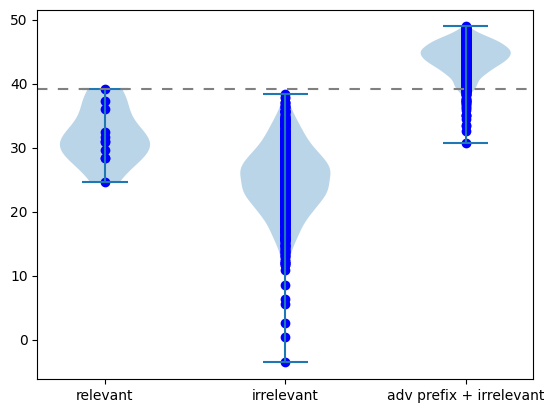

In [31]:
label_positions = [1, 2, 3]
score_lists = [positive_scores, negative_scores, adversarial_negative_scores]

plt.violinplot(score_lists)

plt.xticks(label_positions, ['relevant', 'irrelevant', 'adv prefix + irrelevant'])

for label_pos, score_list in zip(label_positions, score_lists):
    plt.scatter([label_pos]*len(score_list), score_list, color='b')

plt.axhline(max(positive_scores), color='gray', linestyle=(0, (5, 5)))

plt.show()

In [32]:
embds_p = get_document_embeddings(positive_strings)
embds_n = get_document_embeddings(negative_strings)
embds_a = get_document_embeddings(adv_negative_strings)

all_embds = torch.cat((embds_q, embds_p, embds_n), dim=0)

n_q = embds_q.shape[0]
n_p = embds_p.shape[0]

projector = PCA(n_components=2)
projections = projector.fit_transform(all_embds.cpu().numpy())

projections_q, projections_p, projections_n = np.split(projections, np.cumsum([n_q, n_p]))
projections_a = projector.transform(embds_a)

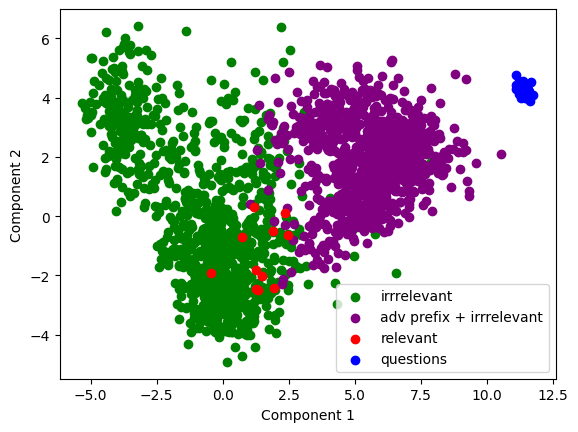

In [34]:
plt.scatter(*zip(*projections_n), color='green', label='irrrelevant')
plt.scatter(*zip(*projections_a), color='purple', label='adv prefix + irrrelevant')
plt.scatter(*zip(*projections_p), color='red', label='relevant')
plt.scatter(*zip(*projections_q), color='blue', label='questions')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.legend()
plt.show()